In [1]:
import sys
import os
import math
import time
import pandas as pd
import numpy as np
from scipy import constants
import seaborn as sb
import matplotlib.pyplot as plt
from spectral import *
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit


h = constants.h
c = constants.c
e = math.e
pi = math.pi
k = constants.k

In [2]:
def load_flux(fluxname):

	with open(fluxname, 'r') as file:
	    data = file.readlines()
	    size = len(data)
	    flux,wavelengths = [],[]
	    for i in range(size):
		    flux.append(float(data[i].strip().split("\t")[1]))
		    wavelengths.append(float(data[i].strip().split("\t")[0]))

	return flux,wavelengths

In [4]:
def planck(T,wav):
	wav = wav*1e-9
	a = 2.0*h*c**2
	b = h*c/(wav*k*T)
	intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
	return intensity/1e12

def load_flux(fluxname):

	with open(fluxname, 'r') as file:
	    data = file.readlines()
	    size = len(data)
	    flux,wavelengths = [],[]
	    for i in range(size):
		    flux.append(float(data[i].strip().split("\t")[1]))
		    wavelengths.append(float(data[i].strip().split("\t")[0]))

	return flux,wavelengths

def rad_list(xp,yp):
    rad = np.zeros(lenw)
    for i in range(len(wavelengths)):
        rad[i] = img_open[xp,yp,i+5]
    return rad

def find_diff(rad,flux,set):
    ratio = flux[145]/rad[145]
    fluxy = []
    for i in range(len(wavelengths)):
        fluxy.append(flux[i]/ratio)
    diff = rad[set]
    return diff

def correct(rad,temp):
    removed = np.zeros(len(wavelengths))
    for i in range(len(wavelengths)):
        removed[i] = rad[i] - 0.95*planck(wavelengths[i], temp)
    return removed

In [63]:
filename = 'ch2_iir_nci_20191210T0124527528_d_img_gds'
#filename = 'ch2_iir_nci_20191202T0639493114_d_img_d18'

start = time.time()

#Load solar flux
flux,wavelengths = load_flux('IIRS_ConvFlux.txt')

#Load spectrum data
img = envi.open(filename + '.hdr', image = filename + '.qub')
img_open = img.open_memmap(writeable = False)

#load required metadata
rows = np.array(range(int(img.metadata['lines'])))
cols = np.array(range(int(img.metadata['samples'])))
lenw = len(wavelengths)

<IPython.core.display.Javascript object>


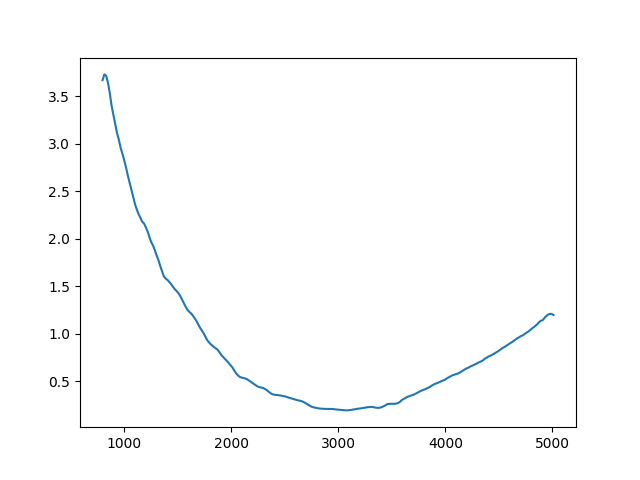

In [72]:
rad = rad_list(8000,120)
rad = savgol_filter(rad, 9, 3) # window size 9, polynomial order 3

plt.plot(wavelengths, rad)

<IPython.core.display.Javascript object>


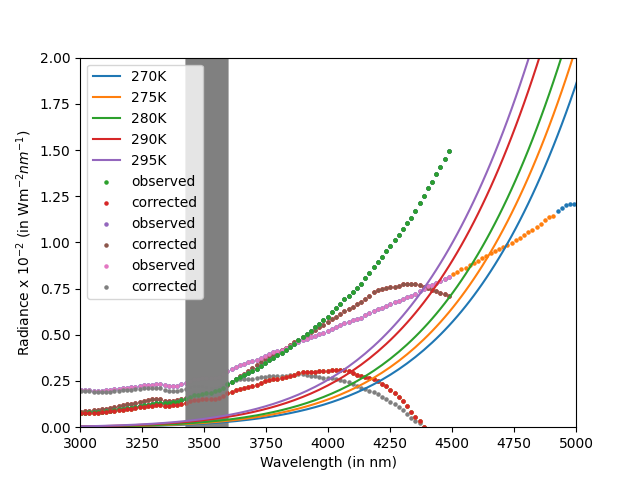

In [73]:
%matplotlib notebook
temps = [270,275,280,290,295]
for t in temps:
    radps = []
    for w in wavelengths:
        radp = planck(w,t)
        radps.append(radp*0.95)
    plt.plot(wavelengths,radps, label=str(t) + 'K')
    
wavenoi,radnoi = [],[]
for i in range(len(wavelengths)):
    if i < 220 or i >244:
        wavenoi.append(wavelengths[i])
        radnoi.append(rad[i])
plt.scatter(wavenoi, radnoi, s = 5)        
#plt.scatter(wavelengths[:220]+wavelengths[245:], rad[:220]+rad[245:], s=5)
plt.scatter(wavelengths[220:245],rad[220:245], s =5)

plt.axvspan(wavelengths[156],wavelengths[166], alpha=0.6, color='grey')

plt.xlim(3000,5000)
plt.ylim(0,2)
plt.xlabel('Wavelength (in nm)')
plt.ylabel('Radiance x 10$^{-2}$ (in Wm$^{-2}nm^{-1}$)')
#plt.grid()
plt.legend()
plt.savefig('planck_issue.png')
plt.show()        

In [74]:
xs = wavelengths[220:245]
ys = [x/0.95 for x in rad[220:245]]

popt, pcov = curve_fit(planck, xs, ys, bounds = (200,400))
print(popt)

[267.73396792]


<IPython.core.display.Javascript object>


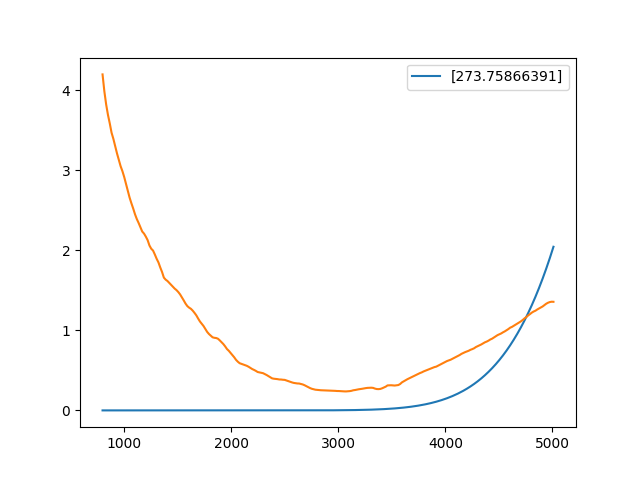

In [67]:
t = popt
radps = []
for w in wavelengths:
    radp = planck(w,t)
    radps.append(radp*0.95)
plt.plot(wavelengths,radps, label=str(t))
plt.plot(wavelengths, rad)
#plt.xlim(2500,5000)
#plt.ylim(0,2)
plt.legend()
plt.show()

In [53]:
def correct(rad,temp):
    removed = np.zeros(len(wavelengths))
    for i in range(len(wavelengths)):
        removed[i] = rad[i] - 0.95*planck(wavelengths[i], temp)
    return removed

In [92]:
corad = correct(rad,t)

plt.scatter(wavelengths[:220], rad[:220], s = 5, label = 'observed')
plt.scatter(wavelengths[:220], corad[:220], s = 5, label = 'corrected')

plt.text(wavelengths[110], 3.1, filename)

plt.axvspan(wavelengths[23],wavelengths[29], alpha=0.6, color='grey')

plt.axvspan(wavelengths[63],wavelengths[70], alpha=0.6, color='grey')

plt.axvspan(wavelengths[156],wavelengths[166], alpha=0.6, color='grey')
plt.xlabel('Wavelength (in nm)')
plt.ylabel('Radiance x 10$^{-2}$ (in Wm$^{-2}nm^{-1}$)')
#plt.xlim(2500,5000)
#plt.ylim(0,2)
#plt.grid()
plt.legend()
plt.show()    

<IPython.core.display.Javascript object>


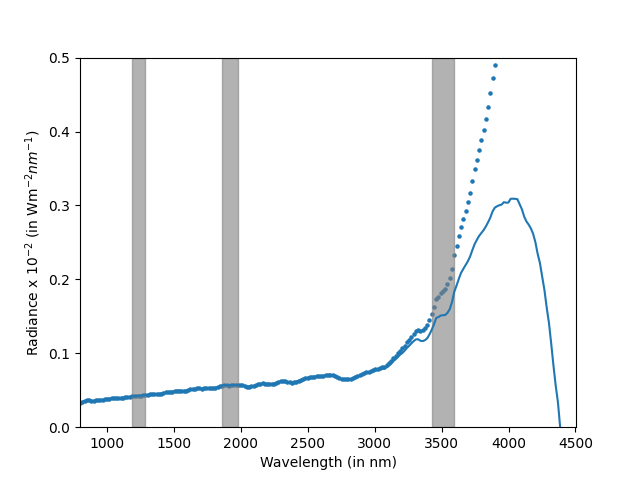

In [93]:
ref = np.zeros(len(wavelengths))
coref = np.zeros(len(wavelengths))

for i in range(len(wavelengths)):
    ref[i] = rad[i]/flux[i]
    coref[i] = corad[i]/flux[i]

%matplotlib notebook

plt.scatter(wavelengths[:220], ref[:220], s = 5, label = 'observed')
plt.plot(wavelengths[:220], coref[:220], label = 'corrected')

plt.text(wavelengths[110], 3.1, filename)

plt.axvspan(wavelengths[23],wavelengths[29], alpha=0.6, color='grey')

plt.axvspan(wavelengths[63],wavelengths[70], alpha=0.6, color='grey')

plt.axvspan(wavelengths[156],wavelengths[166], alpha=0.6, color='grey')
plt.xlabel('Wavelength (in nm)')
plt.ylabel('Radiance x 10$^{-2}$ (in Wm$^{-2}nm^{-1}$)')
plt.xlim(wavelengths[0],wavelengths[220])
plt.ylim(0,0.5)
plt.show()